In [3]:
from aqua import Reader,catalogue, inspect_catalogue
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xr

NameError: name 'xr' is not defined

In [3]:
# We are not looking at scientific validity in the data now. 
# AQUA reader. One note: regrider is not working for 3d variables
reader = Reader(model = 'FESOM', exp = 'tco3999-ng5', source="interpolated_global_TS") 
data = reader.retrieve()

# Dropping the variables, which are not required
data=data.drop("latitude")
data=data.drop("longitude")
data=data.drop("ocpt")
data=data.coarsen(lat=30, lon=40).mean()  #Here will not use AQUA regridder, because it's just fake thing

# Renaming the Variables
data=data.rename({"salt":"so"})
data=data.rename({"temp":"thetao"})
data=data.rename({"depth":"lev"})

# Faking some changes in date for our next codes
data = data.resample(time='7.39H').mean() 
time = np.arange('2011-01-01', '2013-01-01', dtype='datetime64[D]')
data["time"]=time

In [16]:
# There is a issue that if I dont save it and go for the next test without 
# data.to_netcdf("./../../../data.nc")
data=xr.open_dataset("./../../../data.nc")
data["lev"]=data.lev*100

In [17]:
ds2=data.drop("so")
ds3=data.drop("thetao")


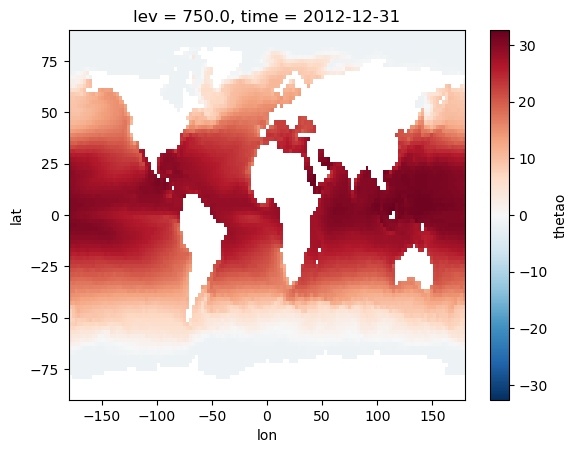

In [18]:
ds2.thetao.resample(time="Y").mean().isel(time=1,lev=1).plot()

In [19]:
# We produce weights (for the regular grid)
weights=np.cos(np.deg2rad(ds2.lat)) # Weights are proportional to the grid cell area, which is influenced by the latd

In [20]:
## We select the different regions for the temperature plots
t3d=ds2.thetao.resample(time="Y").mean()
t3dw=t3d.weighted(weights)

# We create one version with shifted lons for some box averages
t3ds = t3d.assign_coords(lon=(((t3d.lon + 180) % 360) - 180))
# t3ds = t3ds.roll(lon=int(len(t3ds['lon']) / 2), roll_coords=True)

# Global Ocean
t3g=t3d.sel(lat=slice(-90,90), lon=slice(0,360))
wg=np.cos(np.deg2rad(t3g.lat))
t3gw=t3g.weighted(wg)

# Arctic region
t3arc=t3d.sel(lat=slice(65,90), lon=slice(0,360))
warc=np.cos(np.deg2rad(t3arc.lat))
t3arcw=t3arc.weighted(warc)

# Atlantic basin
t3atl=t3ds.sel(lat=slice(-35,65), lon=slice(-80,30))
watl=np.cos(np.deg2rad(t3atl.lat))
t3atlw=t3atl.weighted(watl)
#t3atl[1,1,:,:].plot()

# Southern Ocean basin
t3so=t3ds.sel(lat=slice(-80,-55), lon=slice(-180,180))
wso=np.cos(np.deg2rad(t3so.lat))
t3sow=t3so.weighted(wso)
#t3so[1,1,:,:].plot()

# Pacific  basin
t3pac=t3d.sel(lat=slice(-55,65), lon=slice(120,290))
wpac=np.cos(np.deg2rad(t3pac.lat))
t3pacw=t3pac.weighted(wpac)
#t3pac[1,1,:,:].plot()

# Indian  basin
t3ind=t3d.sel(lat=slice(-35,30), lon=slice(30,115))
wind=np.cos(np.deg2rad(t3ind.lat))
t3indw=t3ind.weighted(wind)
#t3ind[1,1,:,:].plot()

In [21]:
## We select the different regions for the salinity plots
s3d=ds3.so.resample(time="Y").mean()
s3dw=s3d.weighted(weights)

# We create one version with shifted lons for some box averages
s3ds = s3d.assign_coords(lon=(((s3d.lon + 180) % 360) - 180))
# s3ds = s3ds.roll(lon=int(len(s3ds['lon']) / 2), roll_coords=True)

# Global Ocean
s3g=s3d.sel(lat=slice(-90,90), lon=slice(0,360))
wg=np.cos(np.deg2rad(s3g.lat))
s3gw=s3g.weighted(wg)

# Arctic region
s3arc=s3d.sel(lat=slice(65,90), lon=slice(0,360))
warc=np.cos(np.deg2rad(s3arc.lat))
s3arcw=s3arc.weighted(warc)

# Atlantic basin
s3atl=s3ds.sel(lat=slice(-35,65), lon=slice(-80,30))
watl=np.cos(np.deg2rad(s3atl.lat))
s3atlw=s3atl.weighted(watl)
#s3atl[1,1,:,:].plot()

# Southern Ocean basin
s3so=s3ds.sel(lat=slice(-80,-55), lon=slice(-180,180))
wso=np.cos(np.deg2rad(s3so.lat))
s3sow=s3so.weighted(wso)
#s3so[1,1,:,:].plot()

# Pacific  basin
s3pac=s3d.sel(lat=slice(-55,65), lon=slice(120,290))
wpac=np.cos(np.deg2rad(s3pac.lat))
s3pacw=s3pac.weighted(wpac)
#s3pac[1,1,:,:].plot()

# Indian  basin
s3ind=s3d.sel(lat=slice(-35,30), lon=slice(30,115))
wind=np.cos(np.deg2rad(s3ind.lat))
s3indw=s3ind.weighted(wind)
#s3ind[1,1,:,:].plot()

In [22]:
# We compute the regional averages
tg=t3gw.mean(("lat","lon"))
tatl=t3atlw.mean(("lat","lon"))
tpac=t3pacw.mean(("lat","lon"))
tind=t3indw.mean(("lat","lon"))
tarc=t3arcw.mean(("lat","lon"))
tso=t3sow.mean(("lat","lon"))
#
sg=s3gw.mean(("lat","lon"))
satl=s3atlw.mean(("lat","lon"))
spac=s3pacw.mean(("lat","lon"))
sind=s3indw.mean(("lat","lon"))
sarc=s3arcw.mean(("lat","lon"))
sso=s3sow.mean(("lat","lon"))

In [23]:
# Here we identify the levels that represent each selected ocean detph
levs=t3d.lev
ilev0=0

for ilev in range(len(levs)):
 tlev = levs[ilev]
 #print(tlev.values)
# if tlev <= 1000: print(ilev)
# if tlev<= 500: print(ilev)
 if tlev<= 100: ilev100=ilev
 if tlev<= 500: ilev500=ilev
 if tlev<= 1000: ilev1000=ilev
 if tlev<= 2000: ilev2000=ilev
 if tlev<= 3000: ilev3000=ilev
 if tlev<= 4000: ilev4000=ilev
 if tlev<= 5000: ilev5000=ilev
print(ilev0,ilev100,ilev500,ilev1000,ilev2000,ilev3000,ilev4000,ilev5000)

0 1 0 1 3 5 7 9


Text(0.5, 0, 'Time (in years)')

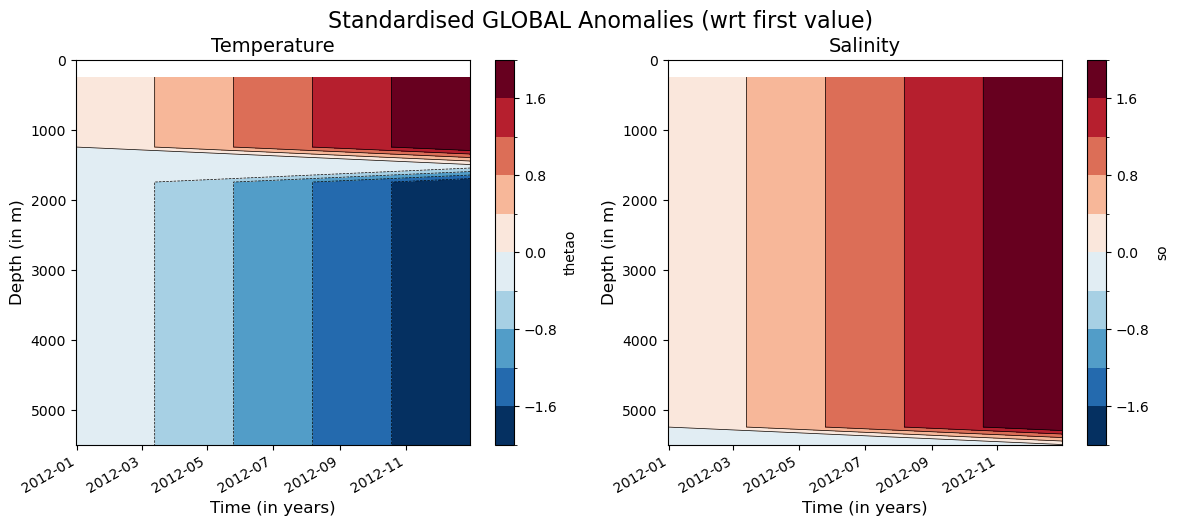

In [24]:
# To compute the temporal anomalies with respect to the initial value in the Global Ocean
tga=tg-tg[0,]
sga=sg-sg[0,]
# Now standardised with respect to the temporal STD at each respective depth
tgs=tga/tga.std("time")
sgs=sga/sga.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised GLOBAL Anomalies (wrt first value)', fontsize=16)

tgt=tgs.transpose()

tgt.plot.contourf(levels=12,ax=ax1)
tgt.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

sgt=sgs.transpose()
sgt.plot.contourf(levels=12, ax=ax2)
sgt.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-Global-standardized-anomalies.png',transparent=True)

Text(0.5, 0, 'Time (in years)')

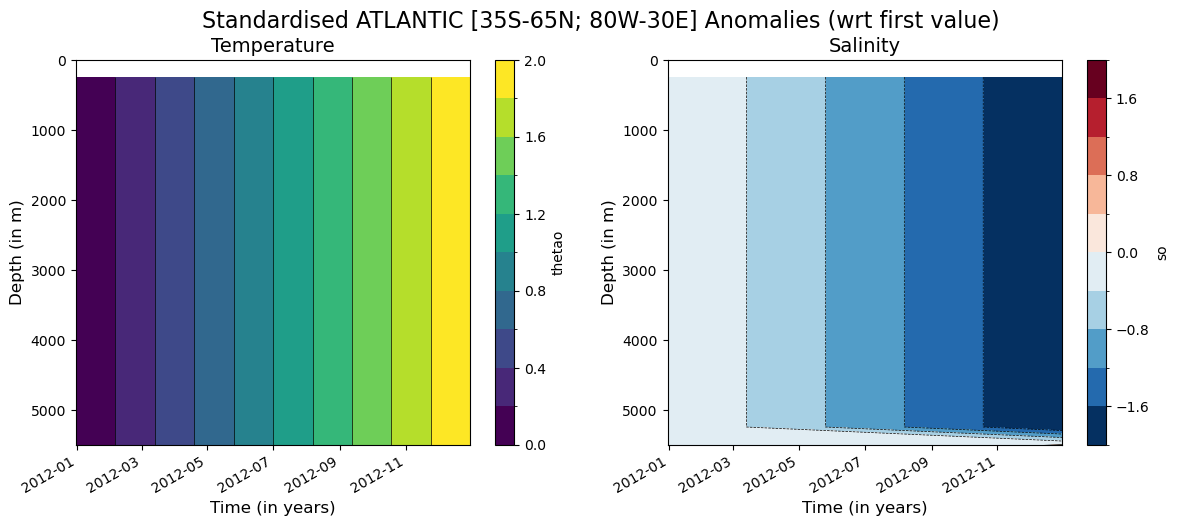

In [25]:
# To compute the temporal anomalies with respect to the initial value in the ATLANTIC Ocean
tatla=tatl-tatl[0,]
satla=satl-satl[0,]
# Now standardised with respect to the temporal STD at each respective depth
tatls=tatla/tatla.std("time")
satls=satla/satla.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised ATLANTIC [35S-65N; 80W-30E] Anomalies (wrt first value)', fontsize=16)

tatlt=tatls.transpose()

tatlt.plot.contourf(levels=12,ax=ax1)
tatlt.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

satlt=satls.transpose()
satlt.plot.contourf(levels=12, ax=ax2)
satlt.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-Atlantic-standardized-anomalies.png',transparent=True)

Text(0.5, 0, 'Time (in years)')

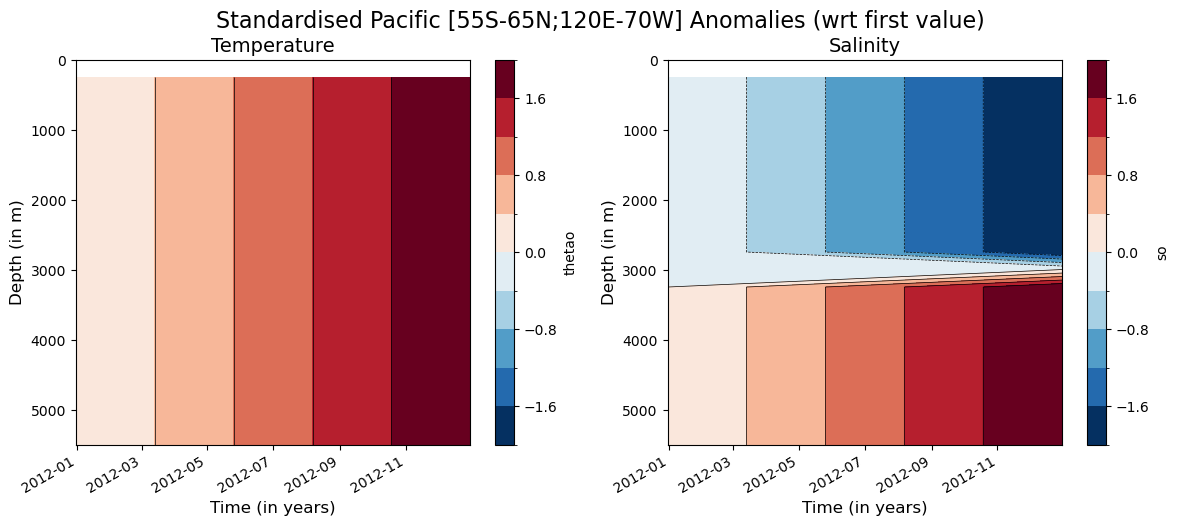

In [26]:
# To compute the temporal anomalies with respect to the initial value in the Pacific Ocean
tpaca=tpac-tpac[0,]
spaca=spac-spac[0,]
# Now standardised with respect to the temporal STD at each respective depth
tpacs=tpaca/tpaca.std("time")
spacs=spaca/spaca.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised Pacific [55S-65N;120E-70W] Anomalies (wrt first value)', fontsize=16)

tpact=tpacs.transpose()

tpact.plot.contourf(levels=12,ax=ax1)
tpact.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

spact=spacs.transpose()
spact.plot.contourf(levels=12, ax=ax2)
spact.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-Pacific-standardized-anomalies.png',transparent=True)

Text(0.5, 0, 'Time (in years)')

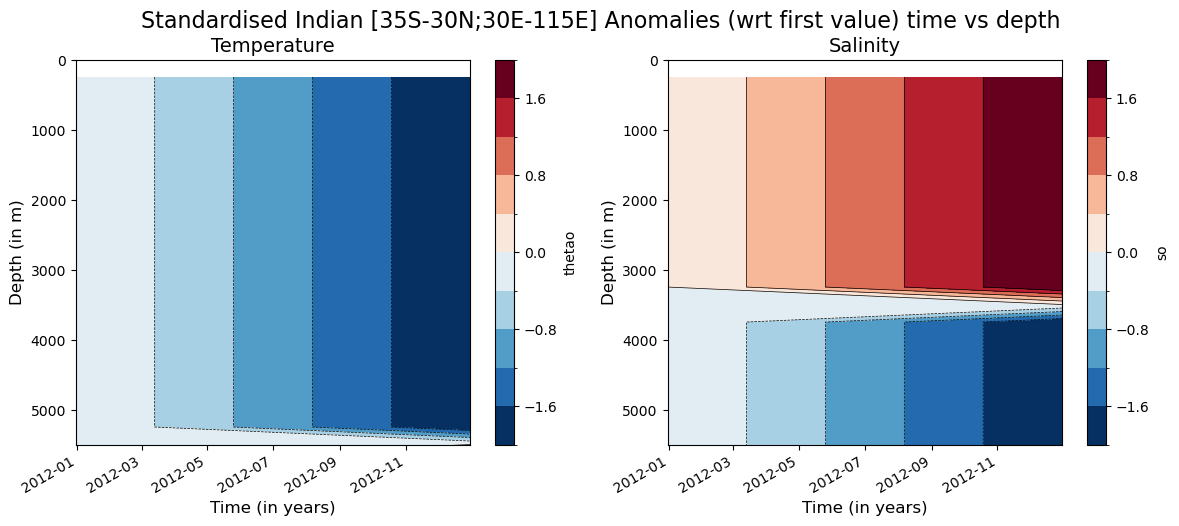

In [27]:
# To compute the temporal anomalies with respect to the initial value in the Indian Ocean
tinda=tind-tind[0,]
sinda=sind-sind[0,]
# Now standardised with respect to the temporal STD at each respective depth
tinds=tinda/tinda.std("time")
sinds=sinda/sinda.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised Indian [35S-30N;30E-115E] Anomalies (wrt first value) time vs depth', fontsize=16)

tindt=tinds.transpose()

tindt.plot.contourf(levels=12,ax=ax1)
tindt.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

sindt=sinds.transpose()
sindt.plot.contourf(levels=12, ax=ax2)
sindt.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-Indian-standardized-anomalies.png',transparent=True)

Text(0.5, 0, 'Time (in years)')

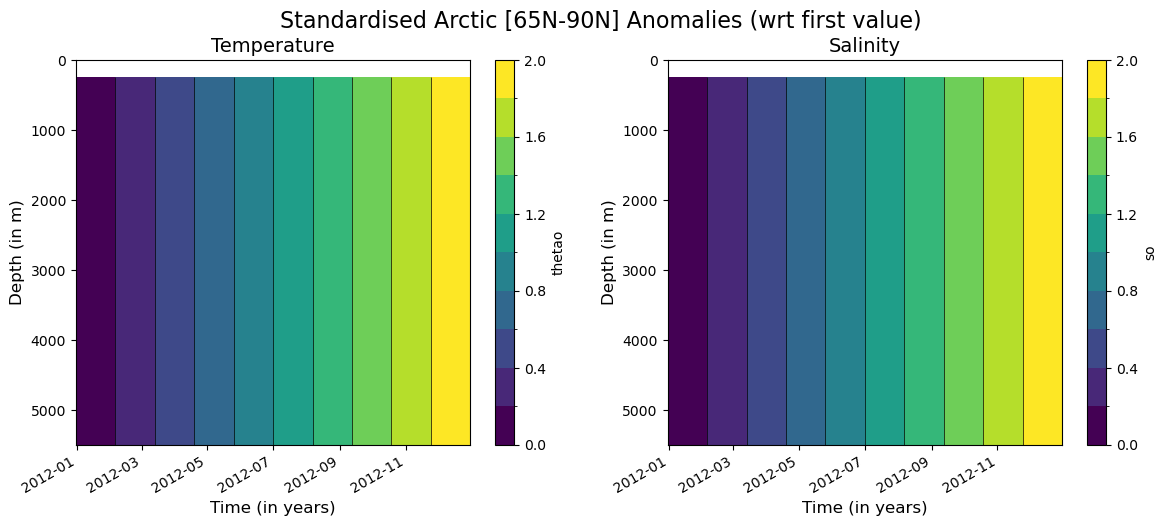

In [28]:
# To compute the temporal anomalies with respect to the initial value in the Arctic Ocean
tarca=tarc-tarc[0,]
sarca=sarc-sarc[0,]
# Now standardised with respect to the temporal STD at each respective depth
tarcs=tarca/tarca.std("time")
sarcs=sarca/sarca.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised Arctic [65N-90N] Anomalies (wrt first value)', fontsize=16)

tarct=tarcs.transpose()

tarct.plot.contourf(levels=12,ax=ax1)
tarct.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

sarct=sarcs.transpose()
sarct.plot.contourf(levels=12, ax=ax2)
sarct.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-Arctic-standardized-anomalies.png',transparent=True)

Text(0.5, 0, 'Time (in years)')

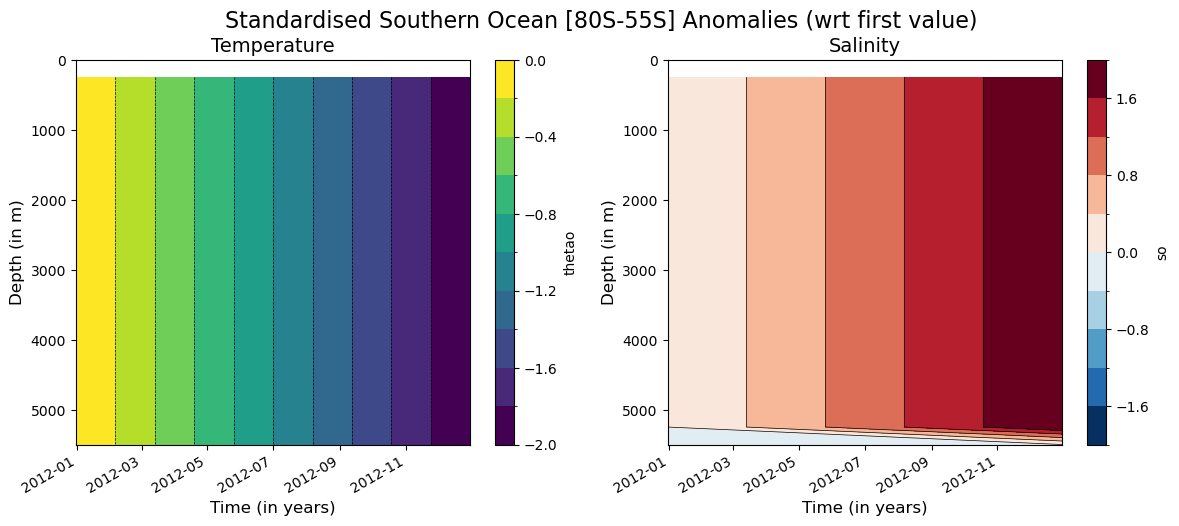

In [29]:
# To compute the temporal anomalies with respect to the initial value in the Southern Ocean
tsoa=tso-tso[0,]
ssoa=sso-sso[0,]
# Now standardised with respect to the temporal STD at each respective depth
tsos=tsoa/tsoa.std("time")
ssos=ssoa/ssoa.std("time")



# And we perform the corresponding hovmoller plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))
fig.suptitle('Standardised Southern Ocean [80S-55S] Anomalies (wrt first value)', fontsize=16)

tsot=tsos.transpose()

tsot.plot.contourf(levels=12,ax=ax1)
tsot.plot.contour(colors="black",levels=12,linewidths=0.5,ax=ax1)
ax1.set_title("Temperature", fontsize=14)
ax1.set_ylim((5500,0))
ax1.set_ylabel("Depth (in m)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)

ssot=ssos.transpose()
ssot.plot.contourf(levels=12, ax=ax2)
ssot.plot.contour(colors="black",levels=12,linewidths=0.5, ax=ax2)
ax2.set_title("Salinity", fontsize=14)
ax2.set_ylim((5500,0))
ax2.set_ylabel("Depth (in m)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)

# plt.savefig('Hovmoller-SouthernOc-standardized-anomalies.png',transparent=True)

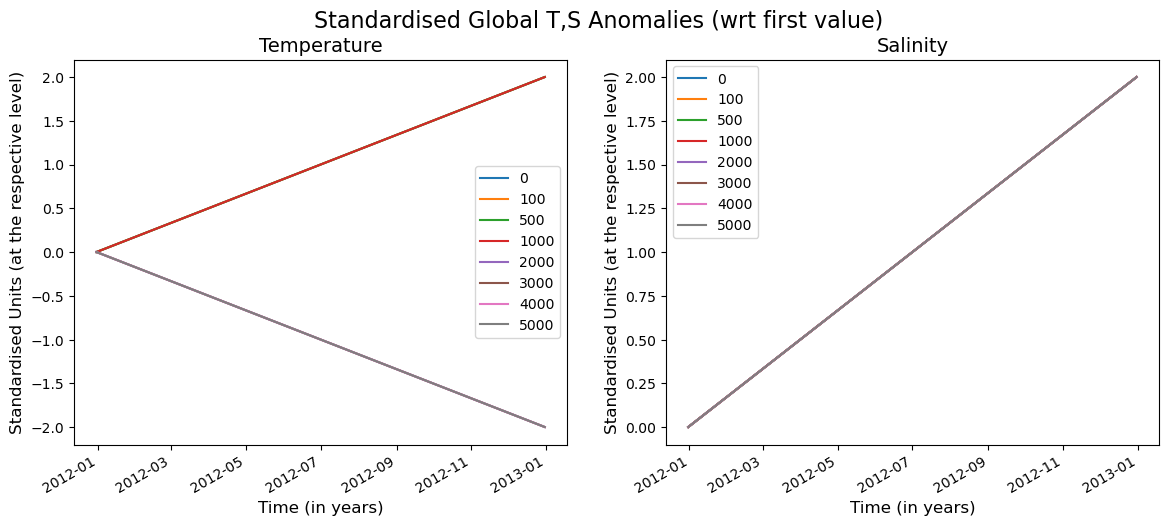

In [30]:
# We now produce timeseries for GLOBAL temperature and salinity standardised anomalies at selected levels

# First for temperature
tg0=tgs[:,ilev0]
tg100=tgs[:,ilev100]
tg500=tgs[:,ilev500]
tg1000=tgs[:,ilev1000]
tg2000=tgs[:,ilev2000]
tg3000=tgs[:,ilev3000]
tg4000=tgs[:,ilev4000]
tg5000=tgs[:,ilev5000]
# Now for salinity
sg0=sgs[:,ilev0]
sg100=sgs[:,ilev100]
sg500=sgs[:,ilev500]
sg1000=sgs[:,ilev1000]
sg2000=sgs[:,ilev2000]
sg3000=sgs[:,ilev3000]
sg4000=sgs[:,ilev4000]
sg5000=sgs[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Global T,S Anomalies (wrt first value)', fontsize=16)

tg0.plot.line(ax=ax1)
tg100.plot.line(ax=ax1)
tg500.plot.line(ax=ax1)
tg1000.plot.line(ax=ax1)
tg2000.plot.line(ax=ax1)
tg3000.plot.line(ax=ax1)
tg4000.plot.line(ax=ax1)
tg5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


sg0.plot.line(ax=ax2)
sg100.plot.line(ax=ax2)
sg500.plot.line(ax=ax2)
sg1000.plot.line(ax=ax2)
sg2000.plot.line(ax=ax2)
sg3000.plot.line(ax=ax2)
sg4000.plot.line(ax=ax2)
sg5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
#ax1.set_legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
plt.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-Global-standardized-anomalies.png',transparent=True)

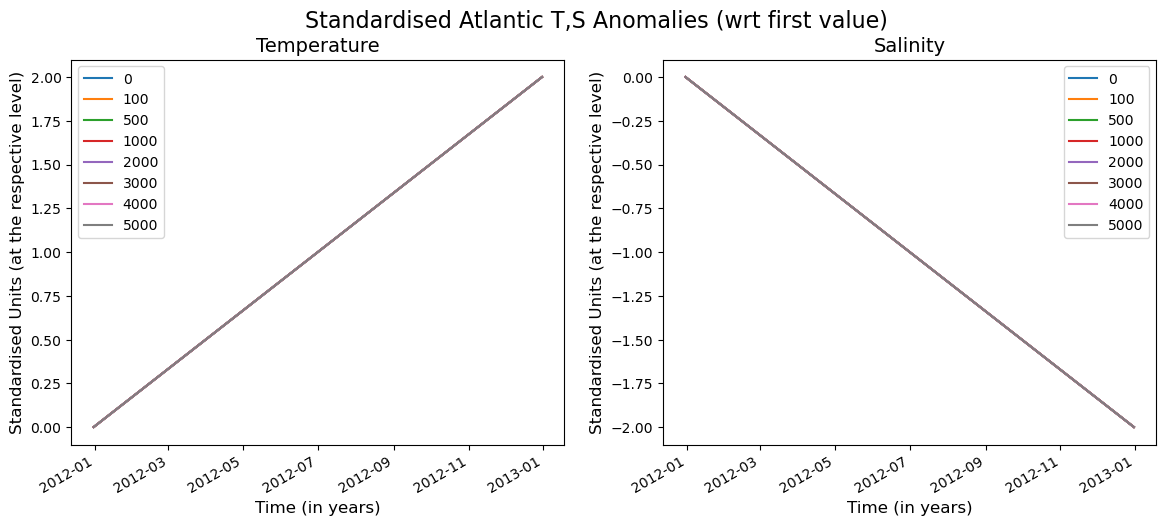

In [31]:
# We now produce timeseries for Attlantic temperature and salinity standardised anomalies at selected levels

# First for temperature
tatl0=tatls[:,ilev0]
tatl100=tatls[:,ilev100]
tatl500=tatls[:,ilev500]
tatl1000=tatls[:,ilev1000]
tatl2000=tatls[:,ilev2000]
tatl3000=tatls[:,ilev3000]
tatl4000=tatls[:,ilev4000]
tatl5000=tatls[:,ilev5000]
# Now for salinity
satl0=satls[:,ilev0]
satl100=satls[:,ilev100]
satl500=satls[:,ilev500]
satl1000=satls[:,ilev1000]
satl2000=satls[:,ilev2000]
satl3000=satls[:,ilev3000]
satl4000=satls[:,ilev4000]
satl5000=satls[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Atlantic T,S Anomalies (wrt first value)', fontsize=16)

tatl0.plot.line(ax=ax1)
tatl100.plot.line(ax=ax1)
tatl500.plot.line(ax=ax1)
tatl1000.plot.line(ax=ax1)
tatl2000.plot.line(ax=ax1)
tatl3000.plot.line(ax=ax1)
tatl4000.plot.line(ax=ax1)
tatl5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


satl0.plot.line(ax=ax2)
satl100.plot.line(ax=ax2)
satl500.plot.line(ax=ax2)
satl1000.plot.line(ax=ax2)
satl2000.plot.line(ax=ax2)
satl3000.plot.line(ax=ax2)
satl4000.plot.line(ax=ax2)
satl5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
ax2.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-Atlantic-standardized-anomalies.png',transparent=True)

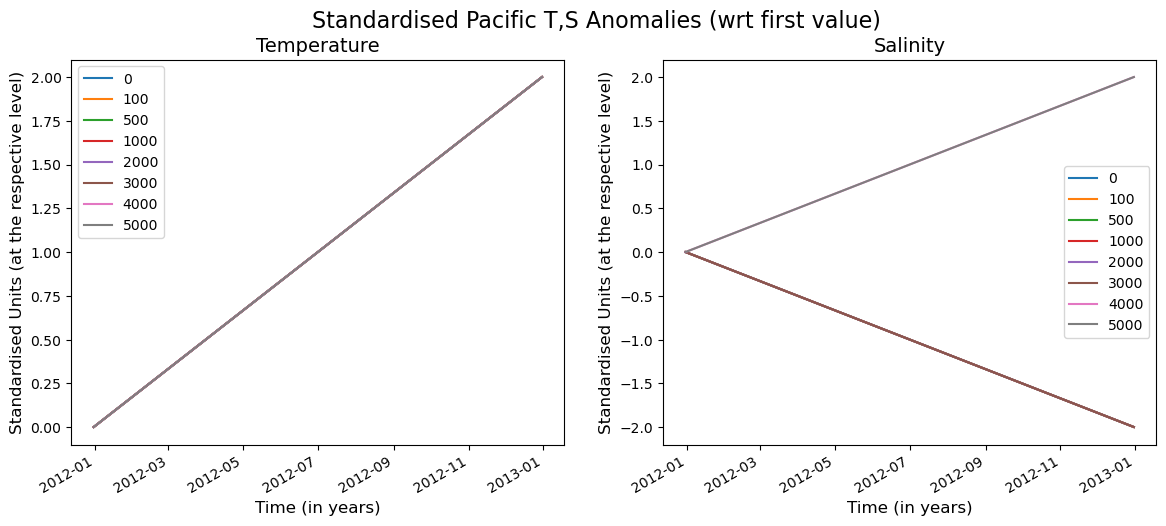

In [32]:
# We now produce timeseries for Pacific temperature and salinity standardised anomalies at selected levels

# First for temperature
tpac0=tpacs[:,ilev0]
tpac100=tpacs[:,ilev100]
tpac500=tpacs[:,ilev500]
tpac1000=tpacs[:,ilev1000]
tpac2000=tpacs[:,ilev2000]
tpac3000=tpacs[:,ilev3000]
tpac4000=tpacs[:,ilev4000]
tpac5000=tpacs[:,ilev5000]
# Now for salinity
spac0=spacs[:,ilev0]
spac100=spacs[:,ilev100]
spac500=spacs[:,ilev500]
spac1000=spacs[:,ilev1000]
spac2000=spacs[:,ilev2000]
spac3000=spacs[:,ilev3000]
spac4000=spacs[:,ilev4000]
spac5000=spacs[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Pacific T,S Anomalies (wrt first value)', fontsize=16)

tpac0.plot.line(ax=ax1)
tpac100.plot.line(ax=ax1)
tpac500.plot.line(ax=ax1)
tpac1000.plot.line(ax=ax1)
tpac2000.plot.line(ax=ax1)
tpac3000.plot.line(ax=ax1)
tpac4000.plot.line(ax=ax1)
tpac5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


spac0.plot.line(ax=ax2)
spac100.plot.line(ax=ax2)
spac500.plot.line(ax=ax2)
spac1000.plot.line(ax=ax2)
spac2000.plot.line(ax=ax2)
spac3000.plot.line(ax=ax2)
spac4000.plot.line(ax=ax2)
spac5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
ax2.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-Pacific-standardized-anomalies.png',transparent=True)

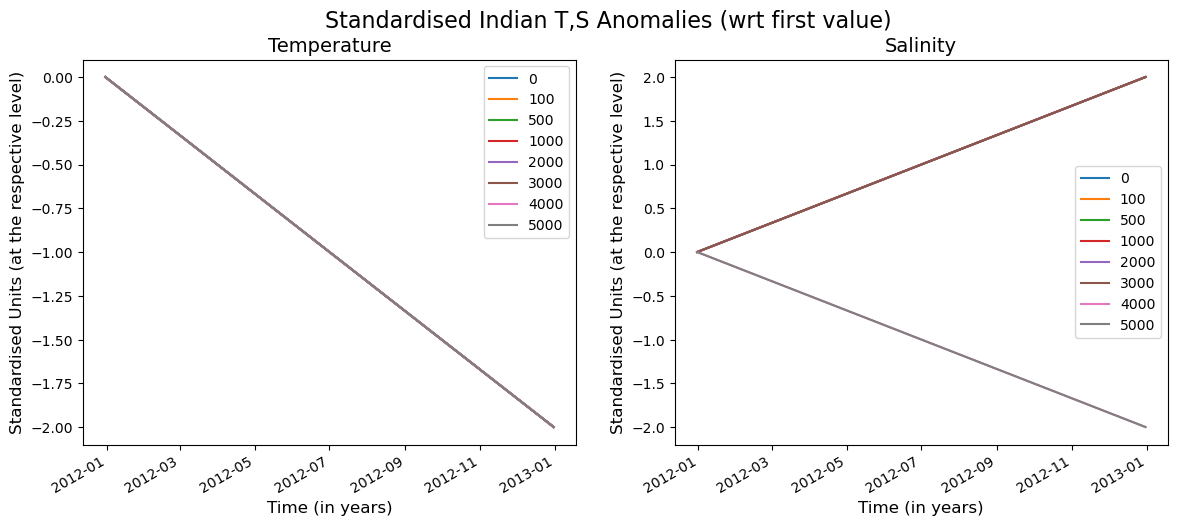

In [33]:
# We now produce timeseries for Indian temperature and salinity standardised anomalies at selected levels

# First for temperature
tind0=tinds[:,ilev0]
tind100=tinds[:,ilev100]
tind500=tinds[:,ilev500]
tind1000=tinds[:,ilev1000]
tind2000=tinds[:,ilev2000]
tind3000=tinds[:,ilev3000]
tind4000=tinds[:,ilev4000]
tind5000=tinds[:,ilev5000]
# Now for salinity
sind0=sinds[:,ilev0]
sind100=sinds[:,ilev100]
sind500=sinds[:,ilev500]
sind1000=sinds[:,ilev1000]
sind2000=sinds[:,ilev2000]
sind3000=sinds[:,ilev3000]
sind4000=sinds[:,ilev4000]
sind5000=sinds[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Indian T,S Anomalies (wrt first value)', fontsize=16)

tind0.plot.line(ax=ax1)
tind100.plot.line(ax=ax1)
tind500.plot.line(ax=ax1)
tind1000.plot.line(ax=ax1)
tind2000.plot.line(ax=ax1)
tind3000.plot.line(ax=ax1)
tind4000.plot.line(ax=ax1)
tind5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


sind0.plot.line(ax=ax2)
sind100.plot.line(ax=ax2)
sind500.plot.line(ax=ax2)
sind1000.plot.line(ax=ax2)
sind2000.plot.line(ax=ax2)
sind3000.plot.line(ax=ax2)
sind4000.plot.line(ax=ax2)
sind5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
ax2.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-Indian-standardized-anomalies.png',transparent=True)

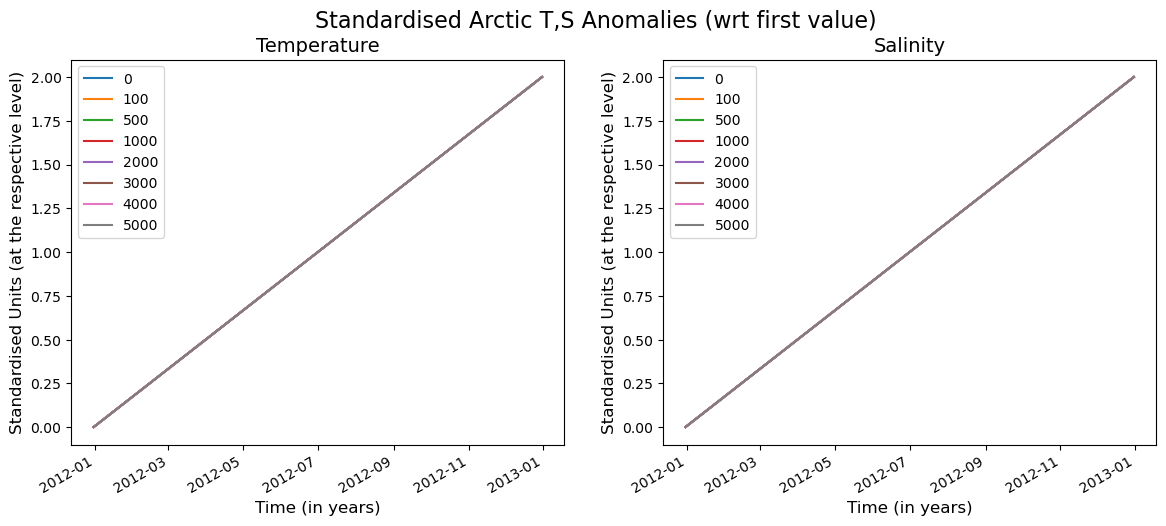

In [34]:
# We now produce timeseries for Arctic temperature and salinity standardised anomalies at selected levels

# First for temperature
tarc0=tarcs[:,ilev0]
tarc100=tarcs[:,ilev100]
tarc500=tarcs[:,ilev500]
tarc1000=tarcs[:,ilev1000]
tarc2000=tarcs[:,ilev2000]
tarc3000=tarcs[:,ilev3000]
tarc4000=tarcs[:,ilev4000]
tarc5000=tarcs[:,ilev5000]
# Now for salinity
sarc0=sarcs[:,ilev0]
sarc100=sarcs[:,ilev100]
sarc500=sarcs[:,ilev500]
sarc1000=sarcs[:,ilev1000]
sarc2000=sarcs[:,ilev2000]
sarc3000=sarcs[:,ilev3000]
sarc4000=sarcs[:,ilev4000]
sarc5000=sarcs[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Arctic T,S Anomalies (wrt first value)', fontsize=16)

tarc0.plot.line(ax=ax1)
tarc100.plot.line(ax=ax1)
tarc500.plot.line(ax=ax1)
tarc1000.plot.line(ax=ax1)
tarc2000.plot.line(ax=ax1)
tarc3000.plot.line(ax=ax1)
tarc4000.plot.line(ax=ax1)
tarc5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


sarc0.plot.line(ax=ax2)
sarc100.plot.line(ax=ax2)
sarc500.plot.line(ax=ax2)
sarc1000.plot.line(ax=ax2)
sarc2000.plot.line(ax=ax2)
sarc3000.plot.line(ax=ax2)
sarc4000.plot.line(ax=ax2)
sarc5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
ax2.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-Arctic-standardized-anomalies.png',transparent=True)

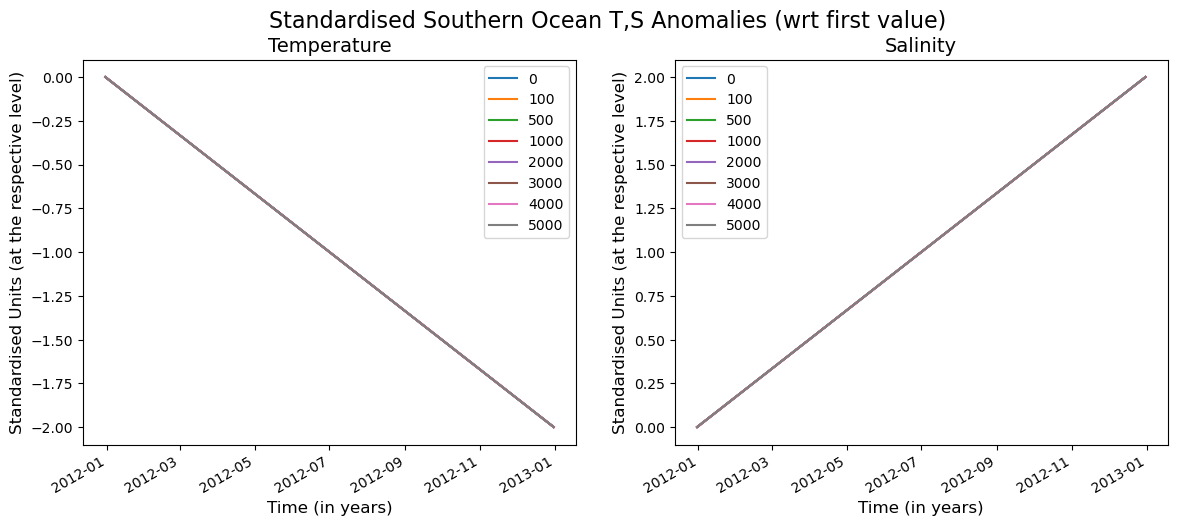

In [35]:
# We now produce timeseries for Southern Ocean temperature and salinity standardised anomalies at selected levels

# First for temperature
tso0=tsos[:,ilev0]
tso100=tsos[:,ilev100]
tso500=tsos[:,ilev500]
tso1000=tsos[:,ilev1000]
tso2000=tsos[:,ilev2000]
tso3000=tsos[:,ilev3000]
tso4000=tsos[:,ilev4000]
tso5000=tsos[:,ilev5000]
# Now for salinity
sso0=ssos[:,ilev0]
sso100=ssos[:,ilev100]
sso500=ssos[:,ilev500]
sso1000=ssos[:,ilev1000]
sso2000=ssos[:,ilev2000]
sso3000=ssos[:,ilev3000]
sso4000=ssos[:,ilev4000]
sso5000=ssos[:,ilev5000]

# Here we produce the multi-panel  plot
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                        figsize=(14,5))

fig.suptitle('Standardised Southern Ocean T,S Anomalies (wrt first value)', fontsize=16)

tso0.plot.line(ax=ax1)
tso100.plot.line(ax=ax1)
tso500.plot.line(ax=ax1)
tso1000.plot.line(ax=ax1)
tso2000.plot.line(ax=ax1)
tso3000.plot.line(ax=ax1)
tso4000.plot.line(ax=ax1)
tso5000.plot.line(ax=ax1)

ax1.set_title("Temperature", fontsize=14)
ax1.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax1.set_xlabel("Time (in years)",fontsize=12)
ax1.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')


sso0.plot.line(ax=ax2)
sso100.plot.line(ax=ax2)
sso500.plot.line(ax=ax2)
sso1000.plot.line(ax=ax2)
sso2000.plot.line(ax=ax2)
sso3000.plot.line(ax=ax2)
sso4000.plot.line(ax=ax2)
sso5000.plot.line(ax=ax2)

ax2.set_title("Salinity", fontsize=14)
ax2.set_ylabel("Standardised Units (at the respective level)",fontsize=12)
ax2.set_xlabel("Time (in years)",fontsize=12)
ax2.legend(["0","100","500","1000","2000","3000","4000","5000"], loc='best')
# plt.savefig('Timeseries-SouthOc-standardized-anomalies.png',transparent=True)